In [49]:
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np 
import torchvision.transforms as transforms
import torch 
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import time
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18():
    return PreActResNet(PreActBlock, [2,2,2,2])

def PreActResNet34():
    return PreActResNet(PreActBlock, [3,4,6,3])

def PreActResNet50():
    return PreActResNet(PreActBottleneck, [3,4,6,3])

def PreActResNet101():
    return PreActResNet(PreActBottleneck, [3,4,23,3])

def PreActResNet152():
    return PreActResNet(PreActBottleneck, [3,8,36,3])


def test():
    net = PreActResNet18()
    y = net((torch.randn(512,3,32,32)))
    print(y.size())

test()

torch.Size([512, 100])


In [55]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

### The data from CIFAR10 will be downloaded in the following folder
rootdir = './data/cifar10'

c10train = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
c10test = CIFAR10(rootdir,train=False,download=True,transform=transform_test)
## number of target samples for the final dataset
num_train_examples = len(c10train)
num_samples_subset = 1500

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647


## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

## We define the Subset using the generated indices 
c10train_subset = torch.utils.data.Subset(c10train,indices[:num_samples_subset])
print(f"Initial CIFAR10 dataset has {len(c10train)} samples")
print(f"Subset of CIFAR10 dataset has {len(c10train_subset)} samples")
batch_size = 256
# Finally we can define anoter dataloader for the training data
trainloader = DataLoader(c10train,batch_size=batch_size,shuffle=True)
testloader = DataLoader(c10test,batch_size=batch_size) 
trainloader_subset = DataLoader(c10train_subset,batch_size=batch_size,shuffle=True)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.



Files already downloaded and verified
Files already downloaded and verified
Initial CIFAR10 dataset has 50000 samples
Subset of CIFAR10 dataset has 1500 samples


In [56]:
model = PreActResNet18()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = CrossEntropyLoss()
x = torch.randn(batch_size,3,32,32, device=device)
y = model((x))
print(y.size())
loss = loss_fn(y, torch.rand_like(y))

torch.Size([256, 100])


In [70]:
def train(model, loader, val_loader,  optimizer, loss_fn, n_epochs=1, save_name=False, plot=False):
    start_time = time.time()
    training_losses = []
    validation_losses = []
    for e in range(n_epochs):
        print("epoch", e)
        for i_batch, batch in enumerate(loader):
            optimizer.zero_grad()
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            outputs = model.forward(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            if i_batch%2==0: print("batch", i_batch, "training loss", loss.item())
        correct = 0
        total = 0
        with torch.inference_mode():
            val_loss = 0
            for i_batch, batch in enumerate(val_loader):
                model.eval()
                images, labels = batch
                images = images.to(device)
                labels = labels.to(device)
                outputs = model.forward(images)
                vloss = loss_fn(outputs, labels)
                val_loss+= vloss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss = val_loss/i_batch
        print(f'accuracy: {100 * correct // total} %', 'val_loss', val_loss)
        training_losses.append(loss.detach().cpu().numpy())
        validation_losses.append(val_loss)

    training_time = start_time-time.time()
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # print(pytorch_total_params)
    if save_name:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'n_epochs': n_epochs,
            'batch_size':batch_size,
            'loss_fn':loss_fn.__str__,
            'total_trainable_params':pytorch_total_params,
            'training_time': training_time,
            }, "./checkpoints/"+save_name)
        
    if plot:
        plt.plot(range(n_epochs),validation_losses)
        plt.plot(range(n_epochs),training_losses)
        plt.legend(['validation loss', 'training loss'])
        plt.show()

        
    
    

epoch 0
batch 0 training loss 4.663817405700684
batch 2 training loss 5.310187339782715
batch 4 training loss 5.604645252227783
accuracy: 6 % val_loss 187.43338873447516
epoch 1
batch 0 training loss 150.28848266601562
batch 2 training loss 2.943662643432617
batch 4 training loss 2.89837908744812
accuracy: 0 % val_loss 2.7451996375352907


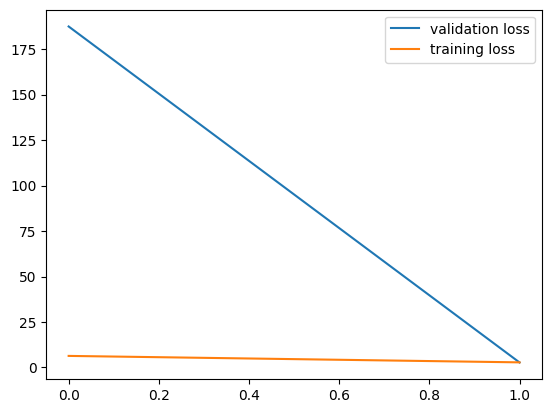

In [71]:
model = PreActResNet18()
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = CrossEntropyLoss()
train(model, trainloader_subset, testloader, optimizer, loss_fn ,n_epochs=2, save_name="trial_1", plot=True)